# `gp.Marginal`

The `gp.Marginal` class implements the more common case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$



## `.marginal_likelihood`

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.  Some sample code would be,

    import numpy as np
    import pymc3 as pm

    # A one dimensional column vector of inputs.
    X = np.linspace(0, 1, 10)[:,None]

    with pm.Model() as marginal_gp_model:
        # Specify the covariance function.
        cov_func = pm.gp.cov.ExpQuad(1, lengthscales=0.1)

        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)

        # The scale of the white noise term can be provided,
        sigma = pm.HalfCauchy("sigma", beta=5)
        y_ = gp.marginal_likelihood("y", n_points=10, X=X, y=y, noise=sigma)
        
        # OR a covariance function for the noise can be given
        noise_l = pm.Gamma("noise_l", alpha=2, beta=2)
        # cov_func_noise = pm.gp.cov.Exponential(1, noise_l)
        # y_ = gp.marginal_likelihood("y", n_points=10, X=X, y=y, noise=cov_func_noise)

## `.conditional`

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  Using the same `gp` object defined above, 

    # vector of new X points we want to predict the function at
    X_star = np.linspace(0, 2, 100)[:, None]
    
    with marginal_gp_model:
        f_star = gp.conditional("f_star", n_points=100, Xnew=X_star)
        
        # or to predict the GP plus noise
        y_star = gp.conditional("y_star", n_points=100, Xnew=X_star, pred_noise=True)

By default, the `gp` object keeps track of `y`, `X`, and `noise` to condition on.  This can be overridden by providing different values as optional keyword arguments,

        f_star_diff = gp.conditional("f_star_diff", n_points=100, X_star, 
                                     X=X_diff, y=y_diff, noise=sigma_diff)
                                     
This is useful when working with additive GP models, for example.  For more information on building additive GPs, see the keeting-curve example.  

## Example: Regression with white, Gaussian noise

This is the same data that was used in the `gp.Latent` example.  The model is equivalent.

In [1]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

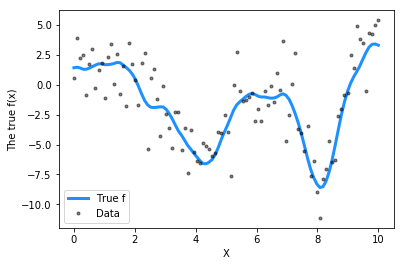

In [2]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
plt.xlabel("X"); plt.ylabel("The true f(x)"); plt.legend();

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
     
    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", n_points=n, X=X, y=y, noise=σ)
    
    mp = pm.find_MAP()#method="L-BFGS-B")

lp = -229.66, ||grad|| = 0.0013279:   0%|          | 99/50000 [00:00<05:27, 152.28it/s]


In [4]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

,Parameter,True value,Value at MAP
0,ℓ,1.0,1.109897
1,η,3.0,3.911457
2,σ,2.0,1.916388


In [15]:
# new values from x=0 to x=20
n_new = 600
X_new = np.linspace(0, 20, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", n_new, X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [03:40<00:00,  8.68it/s]


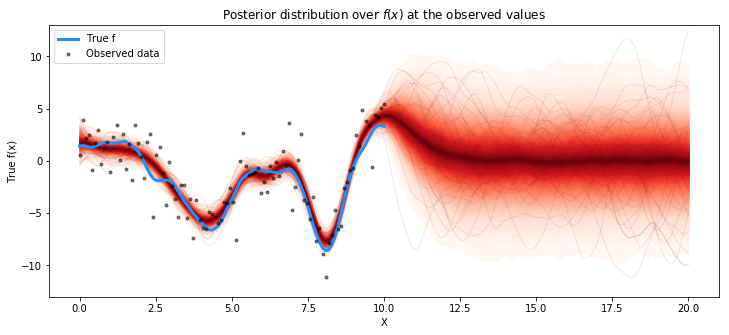

In [16]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();


The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [17]:
with model:
    y_pred = gp.conditional("y_pred", n_new, X_new, pred_noise=True)
    y_samples = pm.sample_ppc([mp], vars=[y_pred], samples=2000)

100%|██████████| 2000/2000 [02:26<00:00, 13.69it/s]


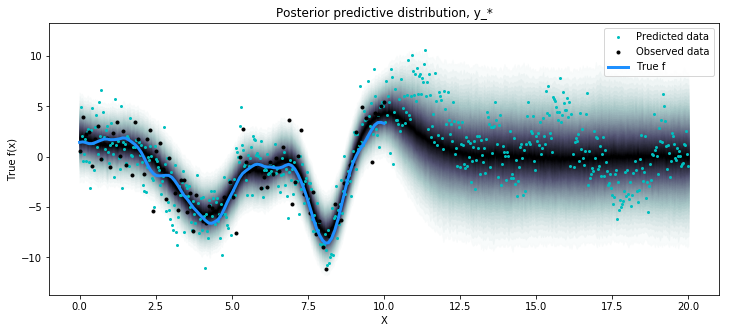

In [22]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");

plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior predictive distribution, y_*"); plt.legend();

Notice that the posterior predictive density is wider than the conditional distribution of the noiseless function, and reflects the predictive distribution of the noisy data, which is marked as black dots.  The light colored dots don't follow the spread of the predictive density exactly because they are a single draw from the posterior of the GP plus noise.